<h1> <center> Dashboard </center> </h1>

In [1]:
import einops
import torch
import numpy as np
from PIL import Image
import json
from json2html import *
import tempfile
import webbrowser
import os

In [2]:
torch.manual_seed(42)
np.random.seed(42)

#### 1. Load the model

In [3]:
from models.TransUNet.model import MyTransUNet, build_the_model

In [4]:
model = build_the_model(
    device="cuda",
    model_path="models/TransUNet/Parameters/transunet_130epo_bce_vit8.meow"
)

model_name = "transunet_70epo_bce_vit8"

Trainable parameters amount: 67076987


#### 2. Load the company test dataset via custom dataloader

In [5]:
from models.TransUNet.dataloader import build_the_dataloader

In [6]:
main_dataloader = build_the_dataloader(
    batch_size=1,
    img_path="/home/student/Documents/Xrays/Data/company_target_images",
    mask_path="/home/student/Documents/Xrays/Data/company_target_masks/",
    name="main_targets"
)

Try to load data from f/home/student/Documents/Xrays/Data/company_target_images
Number of images: 58
Number of masks: 58

Volume of test dataset: 58



In [7]:
jenya_dataloader = build_the_dataloader(
    batch_size=1,
    img_path="/home/student/Documents/Xrays/Data/jenya_target_images",
    mask_path="/home/student/Documents/Xrays/Data/jenya_target_masks",
    name="jenya_targets"
)

Try to load data from f/home/student/Documents/Xrays/Data/jenya_target_images
Number of images: 35
Number of masks: 35

Volume of test dataset: 35



In [8]:
sg_dataloader = build_the_dataloader(
    batch_size=1,
    img_path="/home/student/Documents/Xrays/Data/strange_gun_images_targets",
    mask_path="/home/student/Documents/Xrays/Data/strange_gun_masks_targets",
    name="strange_gun"
)

Try to load data from f/home/student/Documents/Xrays/Data/strange_gun_images_targets
Number of images: 6
Number of masks: 6

Volume of test dataset: 6



# TODO: добавить тестовую выборку (dataloader)

#### 3. Build the Dashboard

In [9]:
from dashboard import Board

In [10]:
def render_fn(x):
    x = x.detach().clone()  # hey, it's really important
    x = einops.rearrange(x, "b c h w -> (b c h) w", b=1, c=1)
    x *= 255
    x = x.to(torch.uint8)
    x = np.array(x.cpu())
    
    return x

In [11]:
board = Board(
    dataloaders=[            # dataloader returns tuple of any types objects
        main_dataloader,
        jenya_dataloader,
        # sg_dataloader
    ],
    model=model,            # model returns object that go right in the measure() and
                            # go in the render() wrapped with render_fn
    model_name=model_name,  # name of the model
    render_fn=render_fn,
    render_dl_idx=0,        # index of dataloader we need to render
    obj_item=1,             # index of element in tuple from dataloader that will be rendered
    obj_name_item=2,        # index of filename
    to_model_item=0,        # image
    limit=1,               # amount of rendered objects
    phs_in_row=2,           # amount of rendered objects in row
    get_randomly=False,     # it's usefull if dataloader is big and 
                            # we want to get different :limit: object from it to render  
    c=3,
    inverse_modelled_obj=True
)

#### 4. Run the Dashboard

Try to form a storage with 58 objects from dataloader. Device: cuda:0
Try to form a storage with 35 objects from dataloader. Device: cuda:0
Storages has been formed
Render...


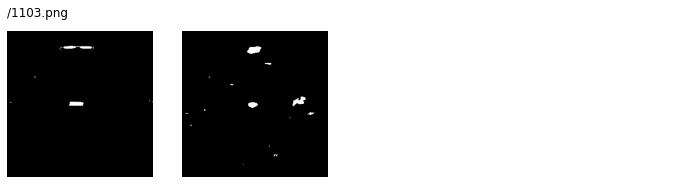

Measure...
Load MSELoss interface from metrics/MSELoss.py
Load IoU interface from metrics/IoU.py
Load MS_SSIM interface from metrics/MS_SSIM.py
metric: MSELoss, val: 0.031116114929318428, idx: 20, name: /home/student/Documents/Xrays/Data/company_target_images/1089.png
metric: IoU, val: 0.465770423412323, idx: 24, name: /home/student/Documents/Xrays/Data/company_target_images/1126.png
metric: MS_SSIM, val: 0.9999484419822693, idx: 49, name: /home/student/Documents/Xrays/Data/company_target_images/1068.png
Load MSELoss interface from metrics/MSELoss.py
Load IoU interface from metrics/IoU.py
Load MS_SSIM interface from metrics/MS_SSIM.py
metric: MSELoss, val: 0.05829009413719177, idx: 24, name: /home/student/Documents/Xrays/Data/jenya_target_images/419.png
metric: IoU, val: 0.29634618759155273, idx: 34, name: /home/student/Documents/Xrays/Data/jenya_target_images/ÑÐ¾Ð»Ð´Ð°Ñ2.png
metric: MS_SSIM, val: 0.9999393224716187, idx: 2, name: /home/student/Documents/Xrays/Data/jenya_target_image

In [12]:
report = board.run()

In [13]:
html = json2html.convert(json=report, table_attributes='border="1px"; border-color: rgba(0,0,255,0.25)')
html = f'<link rel="stylesheet" href="{os.getcwd()}/table.css">' + \
 '<h1><center>Dashboard 📊</center></h1>' + \
 '<div class="table-wrapper"><table class="fl-table">' + \
 html + \
 '</table></div>'

with tempfile.NamedTemporaryFile(mode="w", suffix=".html", delete=False) as tf:
    tf.write(html)
    webbrowser.open('file://' + os.path.realpath(tf.name))